In [1]:
from IPython.display import clear_output
!pip install cleverhans
clear_output()

In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from torch.optim.lr_scheduler import StepLR

import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
print(train_set.data.shape)
print(train_set.data.mean(axis=(0, 1, 2)) / 255)
print(train_set.data.std(axis=(0, 1, 2)) / 255)

Files already downloaded and verified
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [4]:
batch_size = 128
mean       = [0.49139968, 0.48215841, 0.44653091]
std        = [0.24703223, 0.24348513, 0.26158784]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
num_classes = len(CLASSES)

In [5]:
def denormalize(img, mean, std):
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    return np.clip(img, 0, 1)

def show_samples(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:5]
    labels = labels[:5]
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = denormalize(images[i], mean, std)
        ax.imshow(img)
        ax.set_title(f"{CLASSES[labels[i].item()]}", fontsize=20)
        ax.axis("off")
    plt.show()

def show_adv_images_with_labels(adv_examples, true_labels, pred_labels_orig, pred_labels_adv, sample_count=5):
    orig_images, adv_images = adv_examples[0]  # Example batch
    fig, axes = plt.subplots(3, sample_count, figsize=(15, 8))
    for i in range(sample_count):
        orig = denormalize(orig_images[i].detach().cpu(), mean, std)
        adv = denormalize(adv_images[i].detach().cpu(), mean, std)
        diff = np.abs(adv - orig)

        true_label = CLASSES[true_labels[i]]
        orig_pred_label = CLASSES[pred_labels_orig[i]]
        adv_pred_label = CLASSES[pred_labels_adv[i]]

        axes[0, i].imshow(orig)
        axes[0, i].set_title(f"True: {true_label}\nPred: {orig_pred_label}")
        axes[0, i].axis("off")
        axes[1, i].imshow(adv)
        axes[1, i].set_title(f"Adversarial\nPred: {adv_pred_label}")
        axes[1, i].axis("off")
        axes[2, i].imshow(diff)
        axes[2, i].set_title("Difference")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()

def visualize_adversarial_samples(generator, test_loader, model, sapmple_count=7):
    generator.eval(), model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:sapmple_count].to(device), labels[:sapmple_count].to(device)
    
    with torch.no_grad():
        perturbations = generator(images)
        adv_images = images + perturbations
        adv_preds = model(adv_images).argmax(dim=1)

    images = images.cpu()
    adv_images = adv_images.cpu()
    perturbations = perturbations.cpu()
    adv_preds = adv_preds.cpu()

    fig, axes = plt.subplots(3, sapmple_count, figsize=(20, 10))
    for i in range(sapmple_count):
        axes[0, i].imshow(denormalize(images[i], mean, std))
        axes[0, i].set_title(f"Original: {CLASSES[labels[i]]}")
        axes[0, i].axis("off")
        axes[1, i].imshow(denormalize(adv_images[i], mean, std))
        axes[1, i].set_title(f"Adversarial: {CLASSES[adv_preds[i]]}")  # Display predicted label
        axes[1, i].axis("off")
        axes[2, i].imshow(denormalize(perturbations[i], mean, std), cmap="seismic")
        axes[2, i].set_title("Perturbation")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()


def plot_losses(epochs, g_losses, d_losses, attack_success_rates, val_g_losses, val_d_losses, val_attack_success_rates, d_accuracies, val_d_accuracies):
    actual_epochs = len(g_losses)    
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 3, 1)
    plt.plot(range(1, actual_epochs + 1), g_losses, label='Generator Loss', color='blue')
    plt.plot(range(1, actual_epochs + 1), d_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    
    plt.subplot(2, 3, 2)
    plt.plot(range(1, actual_epochs + 1), attack_success_rates, label='Attack Success Rate', color='orange')
    plt.plot(range(1, actual_epochs + 1), val_attack_success_rates, label='Validation Attack Success Rate', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Success Rate')
    plt.title('Attack Success Rates')
    plt.legend()
    
    plt.subplot(2, 3, 3)
    plt.plot(range(1, actual_epochs + 1), val_g_losses, label='Validation Generator Loss', color='blue')
    plt.plot(range(1, actual_epochs + 1), val_d_losses, label='Validation Discriminator Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Generator and Discriminator Losses')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(range(1, actual_epochs + 1), d_accuracies, label='Train Acc', color='blue')
    plt.plot(range(1, actual_epochs + 1), val_d_accuracies, label='Validation Acc', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.title('Discriminator Accuracies')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confidence_histograms(target_model, test_loader, generator):
    normal_confidences = []
    adversarial_confidences = []

    generator.eval()
    target_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = images + perturbations
            normal_outputs = torch.softmax(target_model(images), dim=1)
            adv_outputs = torch.softmax(target_model(adv_images), dim=1)

            normal_confidences.extend(normal_outputs.max(1)[0].cpu().numpy())
            adversarial_confidences.extend(adv_outputs.max(1)[0].cpu().numpy())
    plt.figure(figsize=(10, 5))
    plt.hist(adversarial_confidences, bins=20, alpha=0.7, label="Adversarial Samples", color="red")
    plt.hist(normal_confidences, bins=20, alpha=0.7, label="Normal Samples", color="blue")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.title("Confidence Histogram: Normal vs Adversarial")
    plt.legend()
    plt.show()

In [6]:
def calculate_attack_success(target_model, test_loader, generator):
    overall_success = 0
    per_class_success = np.zeros(num_classes)
    per_class_count = np.zeros(num_classes)

    generator.eval()
    target_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = images + perturbations
            # adv_images = torch.clamp(images + perturbations, -1, 1)
            adv_outputs = target_model(adv_images)
            _, adv_preds = adv_outputs.max(1)
            fooled = (adv_preds != labels).cpu().numpy()
            overall_success += fooled.sum()
            for label, is_fooled in zip(labels.cpu().numpy(), fooled):
                per_class_count[label] += 1
                per_class_success[label] += is_fooled
    overall_rate = overall_success / sum(per_class_count)
    per_class_rate = per_class_success / per_class_count
    return overall_rate, per_class_rate

In [7]:
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
print(dataset.data.shape)
print(dataset.data.mean(axis=(0, 1, 2)) / 255)
print(dataset.data.std(axis=(0, 1, 2)) / 255)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Split training dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

Files already downloaded and verified
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
Files already downloaded and verified


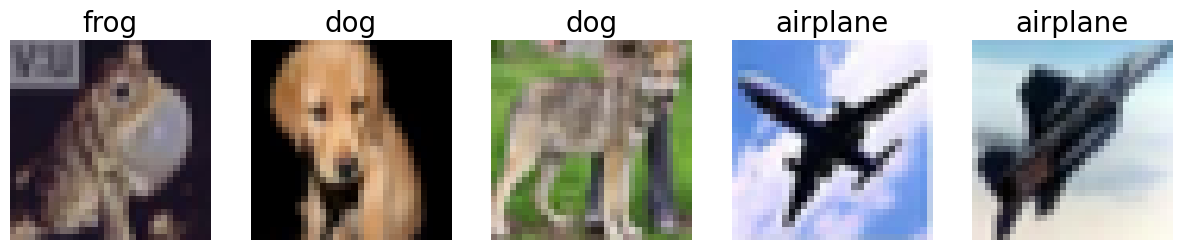

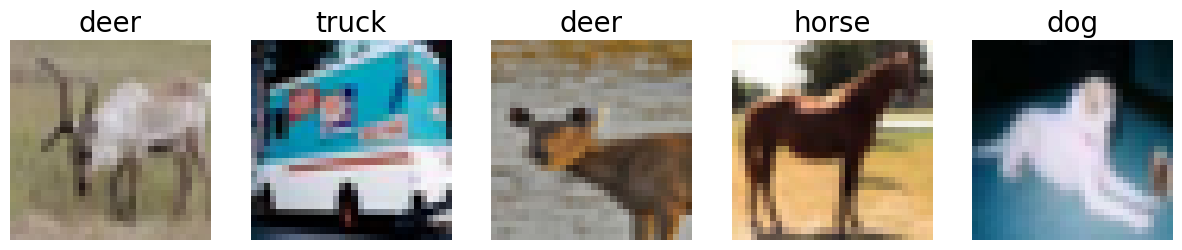

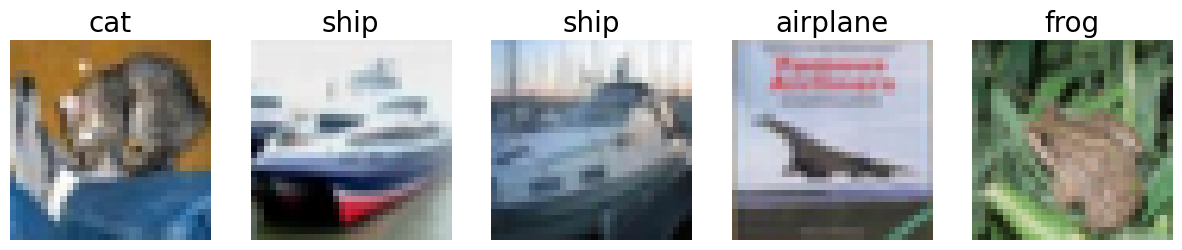

In [8]:
show_samples(train_loader)
show_samples(val_loader)
show_samples(test_loader)

In [9]:
target_model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True
).to(device)
target_model.eval()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [10]:
# Evaluate accuracy on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 92.12%


In [11]:
# Generate adversarial images using FGSM
epsilon = 0.01
total, success = 0, 0
adv_examples = []
true_labels = []
pred_labels_orig = []
pred_labels_adv = []

target_model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    adv_images = fast_gradient_method(target_model, images, epsilon, norm=np.inf)
    adv_examples.append((images, adv_images))
    true_labels.extend(labels.cpu().numpy())
    
    with torch.no_grad():
        orig_preds = target_model(images).argmax(dim=1)
        adv_preds = target_model(adv_images).argmax(dim=1)
        pred_labels_orig.extend(orig_preds.cpu().numpy())
        pred_labels_adv.extend(adv_preds.cpu().numpy())
        success += (labels != adv_preds).sum().item()
        total += images.size(0)

print(f"Attack Success Rate: {(success / total) * 100:.2f}%")

Attack Success Rate: 36.32%


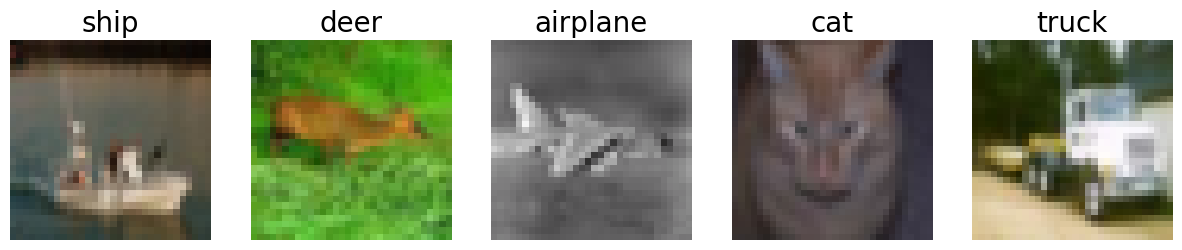

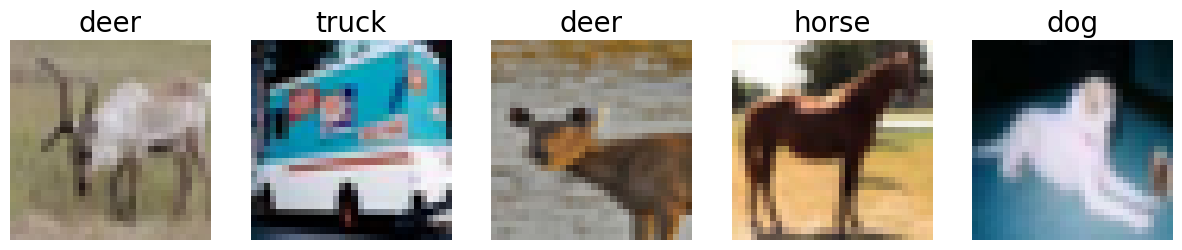

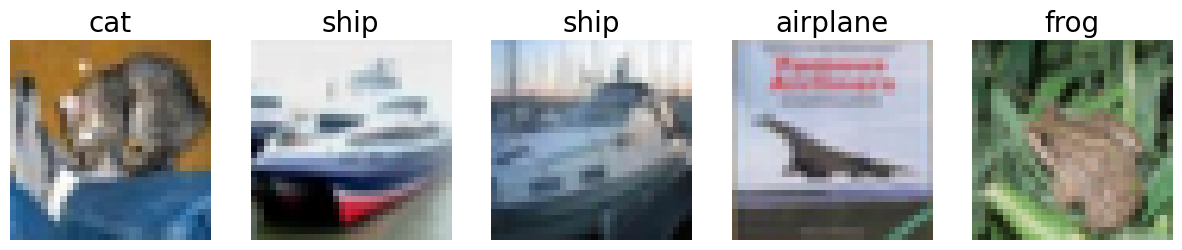

In [12]:
show_samples(train_loader)
show_samples(val_loader)
show_samples(test_loader)

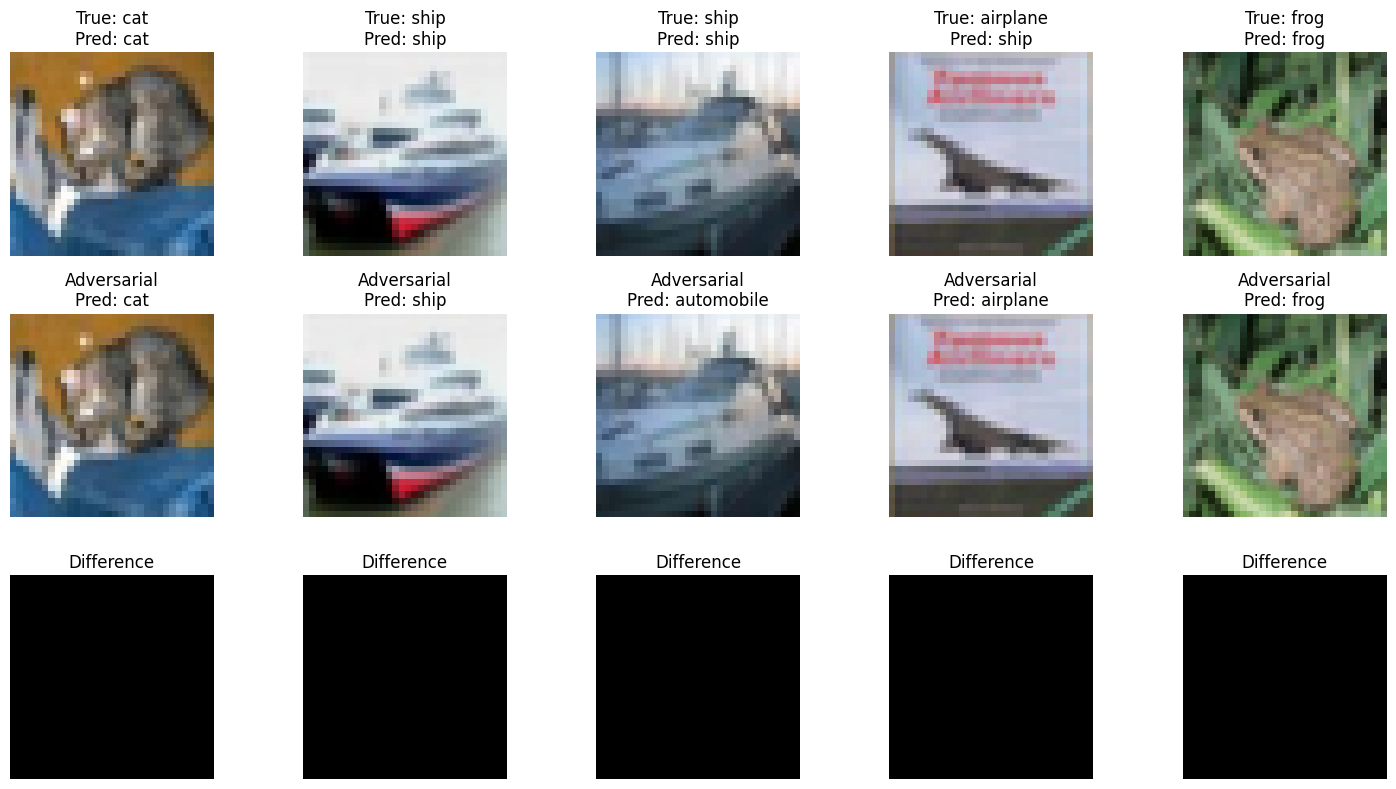

In [13]:
show_adv_images_with_labels(adv_examples, true_labels, pred_labels_orig, pred_labels_adv)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32)
            ###################################################
            # nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1), 
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(16),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(32),
            ###################################################
            # nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), 
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(256),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(512)
        )
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
            ###################################################
            # nn.ReLU(),
            # nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(16),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(8),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.Tanh()
            ###################################################
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(256),
            # # nn.Dropout(0.3),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(128),
            # # nn.Dropout(0.3),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(64),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.Tanh()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ###################################################
            # nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            # nn.BatchNorm2d(16),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            # nn.BatchNorm2d(32),
            # nn.LeakyReLU(0.2, inplace=True)
            # nn.Conv2d(32, 1, kernel_size=4),  # 4x4 -> 1x1
            # nn.Sigmoid()  # Normalize output to [0, 1]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the (32, 4, 4) output to (512)
            nn.Linear(32 * 4 * 4, 1),  # Linear layer for classification
            nn.Sigmoid()  # Normalize output to [0, 1]
        )
    
    def forward(self, x):
        # return self.model(x).view(-1)
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output.view(-1)

In [15]:
class LossFunctions:
    @staticmethod
    def gan_loss():
        return nn.MSELoss()

    @staticmethod
    def adv_loss(logits, target, kappa=0):
        target_one_hot = torch.eye(num_classes).type(logits.type())[target.long()]
        real = torch.sum(target_one_hot * logits, 1)
        other = torch.max((1 - target_one_hot) * logits - (target_one_hot * 10000), 1)[0]
        kappa = torch.zeros_like(other).fill_(kappa)
        return torch.sum(torch.max(real - other, kappa))

    @staticmethod
    def hinge_loss(perturb, c):
        norm = torch.norm(perturb.view(perturb.size(0), -1), dim=1)
        clamped = torch.clamp(norm - c, min=0)
        return torch.mean(clamped)

    @staticmethod
    def total_loss(adv_loss_value, gan_loss_value, hinge_loss_value, alpha, beta):
        return alpha * gan_loss_value + beta * hinge_loss_value + adv_loss_value

    @staticmethod
    def total_gan_loss(real_loss, fake_loss):
        return real_loss + fake_loss
        real_loss = LossFunctions.gan_loss()(D(images), torch.ones(batch_size, device=device))
        fake_loss = LossFunctions.gan_loss()(D(adversarial_images.detach()), torch.zeros(batch_size, device=device))

In [16]:
def attack_success(model, adversarial_images, labels):
    with torch.no_grad():
        adv_preds = model(adversarial_images).argmax(dim=1)
        success = (labels != adv_preds).sum().item()
    return success

def train_epoch(epoch, G, D, train_loader, optimizer_G, optimizer_D, target_model, alpha, beta, epochs):
    G.train(), D.train()
    train_g_loss, train_d_loss, train_attack_success_counts, train_correct_d = 0, 0, 0, 0
    total_samples = 0
    tepoch = tqdm(train_loader, unit="batch", desc=f"Training Epoch {epoch+1}/{epochs}", ncols=100, leave=False)
    for batch_idx, (images, labels) in enumerate(tepoch):
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        total_samples += batch_size

        G.eval(), D.train()
        perturbations = G(images)
        adversarial_images = images + perturbations

        if (epoch % 13 == 0): 
            optimizer_D.zero_grad()
            d_loss = LossFunctions.total_gan_loss(
                real_loss=LossFunctions.gan_loss()(D(images), torch.ones(batch_size, device=device)),
                fake_loss=LossFunctions.gan_loss()(D(adversarial_images.detach()), torch.zeros(batch_size, device=device))
            )
            d_loss.backward()
            optimizer_D.step()

        train_correct_d += ((D(images) > 0.5).sum() + (D(adversarial_images) < 0.5).sum()).item()
        
        G.train(), D.eval()
        optimizer_G.zero_grad()
        g_loss = LossFunctions.total_loss(
            adv_loss_value=LossFunctions.adv_loss(target_model(adversarial_images), labels),
            gan_loss_value=LossFunctions.gan_loss()(D(adversarial_images), torch.ones(batch_size, device=device)), 
            hinge_loss_value=LossFunctions.hinge_loss(perturbations, c), 
            alpha=alpha, beta=beta
        )
        g_loss.backward()
        optimizer_G.step()

        train_g_loss += g_loss.item()
        if (epoch % 13 == 0): 
            train_d_loss += d_loss.item()
            tepoch.set_postfix({'Batch': batch_idx + 1, 'G_Loss': g_loss.item(), 'D_Loss': d_loss.item()})
        train_attack_success_counts += attack_success(target_model, adversarial_images, labels)
    return (train_g_loss / len(train_loader)), (train_d_loss / len(train_loader)), (train_attack_success_counts / len(train_dataset)), (train_correct_d / (total_samples * 2))

def validate_epoch(G, D, val_loader, target_model, alpha, beta):
    G.eval(), D.eval()
    val_g_loss, val_d_loss, val_attack_success_counts, val_correct_d = 0, 0, 0, 0
    total_samples = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            batch_size = val_images.size(0)
            total_samples += batch_size
            val_perturbations = G(val_images)
            val_adversarial_images = val_images + val_perturbations
            val_d_loss_batch = LossFunctions.total_gan_loss(
                real_loss = LossFunctions.gan_loss()(D(val_images), torch.ones(batch_size, device=device)),
                fake_loss = LossFunctions.gan_loss()(D(val_adversarial_images), torch.zeros(batch_size, device=device))
            )
            val_g_loss_batch = LossFunctions.total_loss(
                adv_loss_value=LossFunctions.adv_loss(target_model(val_adversarial_images), val_labels),
                gan_loss_value=LossFunctions.gan_loss()(D(val_adversarial_images), torch.ones(batch_size, device=device)), 
                hinge_loss_value=LossFunctions.hinge_loss(val_perturbations, c), 
                alpha=alpha, beta=beta
            )

            val_correct_d += ((D(val_images) > 0.5).sum() + (D(val_adversarial_images) < 0.5).sum()).item()

            val_g_loss += val_g_loss_batch.item()
            val_d_loss += val_d_loss_batch.item()
            val_attack_success_counts += attack_success(target_model, val_adversarial_images, val_labels)
    return (val_g_loss/len(val_loader)), (val_d_loss/len(val_loader)), (val_attack_success_counts/len(val_dataset)), (val_correct_d / (total_samples * 2))

In [17]:
epochs   = 50 
lr       = 0.001
alpha    = 11.0 # param alpha: Weight for adversarial loss (LGAN) 
beta     = 15.0 # param beta: Weight for hinge loss (Lhinge)
# alpha    = 1.0 # param alpha: Weight for adversarial loss (LGAN) 
# beta     = 10.0 # param beta: Weight for hinge loss (Lhinge)
c        = 8 / (255 * torch.tensor(std).max().item()) # param c: Hinge loss bound
patience = 16

G = Generator().to(device)
D = Discriminator().to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

g_scheduler = StepLR(optimizer_G, step_size=8, gamma=0.5)
d_scheduler = StepLR(optimizer_D, step_size=8, gamma=0.5)

In [18]:
best_val_loss = float('inf')
patience_counter = 0
g_losses, d_losses, g_accuracies, d_accuracies = [], [], [], []
val_g_losses, val_d_losses, val_d_accuracies = [], [], []
attack_success_rates, val_attack_success_rates = [], []

for epoch in range(epochs):
    g_loss, d_loss, attack_success_rate, d_acc = train_epoch(
        epoch, G, D, train_loader, optimizer_G, optimizer_D, target_model, alpha, beta, epochs
    )
    g_losses.append(g_loss)
    d_losses.append(d_loss)
    d_accuracies.append(d_acc)
    attack_success_rates.append(attack_success_rate)
    
    val_g_loss, val_d_loss, val_attack_success_rate, val_d_acc = validate_epoch(
        G, D, val_loader, target_model, alpha, beta
    )
    val_g_losses.append(val_g_loss)
    val_d_losses.append(val_d_loss)
    val_d_accuracies.append(val_d_acc)
    val_attack_success_rates.append(val_attack_success_rate)
    
    print(f"Epoch {epoch+1}/{epochs} | g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}, val_g_loss: {val_g_loss:.4f}, val_d_loss: {val_d_loss:.4f}, attack_success_rate: {attack_success_rate:.4f}, val_attack_success_rate: {val_attack_success_rate:.4f}")
    if patience_counter == 3:
        g_scheduler.step(), d_scheduler.step()
        print(f"Generator Lr: {g_scheduler.get_last_lr()[0]}, Discriminator Lr: {d_scheduler.get_last_lr()[0]}") 
    if val_g_loss < best_val_loss:
        best_val_loss = val_g_loss
        patience_counter = 0
        torch.save(G.state_dict(), 'best_generator.pth')
        torch.save(D.state_dict(), 'best_discriminator.pth')
    else:
        print(f"Patience counter: {patience_counter + 1}/{patience}")
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

Epoch 1/50 | g_loss: 336.8505, d_loss: 0.0358, val_g_loss: 165.3337, val_d_loss: 0.8223, attack_success_rate: 0.7702, val_attack_success_rate: 0.8873


Epoch 2/50 | g_loss: 152.8045, d_loss: 0.0000, val_g_loss: 145.0487, val_d_loss: 0.8520, attack_success_rate: 0.9025, val_attack_success_rate: 0.8868


Epoch 3/50 | g_loss: 140.0720, d_loss: 0.0000, val_g_loss: 137.5531, val_d_loss: 0.8789, attack_success_rate: 0.9104, val_attack_success_rate: 0.8912


Epoch 4/50 | g_loss: 134.0433, d_loss: 0.0000, val_g_loss: 131.0340, val_d_loss: 0.8643, attack_success_rate: 0.9129, val_attack_success_rate: 0.9108


Epoch 5/50 | g_loss: 129.7572, d_loss: 0.0000, val_g_loss: 128.5286, val_d_loss: 0.8996, attack_success_rate: 0.9168, val_attack_success_rate: 0.9357


Epoch 6/50 | g_loss: 126.5284, d_loss: 0.0000, val_g_loss: 126.5433, val_d_loss: 0.8711, attack_success_rate: 0.9173, val_attack_success_rate: 0.9215


Epoch 7/50 | g_loss: 123.7000, d_loss: 0.0000, val_g_loss: 127.9554, val_d_loss: 0.8416, attack_success_rate: 0.9206, val_attack_success_rate: 0.8956
Patience counter: 1/16


Epoch 8/50 | g_loss: 121.9986, d_loss: 0.0000, val_g_loss: 132.7150, val_d_loss: 0.7905, attack_success_rate: 0.9222, val_attack_success_rate: 0.8677
Patience counter: 2/16


Epoch 9/50 | g_loss: 120.5471, d_loss: 0.0000, val_g_loss: 126.0061, val_d_loss: 0.8223, attack_success_rate: 0.9212, val_attack_success_rate: 0.8982


Epoch 10/50 | g_loss: 118.8680, d_loss: 0.0000, val_g_loss: 121.9631, val_d_loss: 0.8127, attack_success_rate: 0.9235, val_attack_success_rate: 0.9158


Epoch 11/50 | g_loss: 117.6600, d_loss: 0.0000, val_g_loss: 121.1338, val_d_loss: 0.7762, attack_success_rate: 0.9237, val_attack_success_rate: 0.9105


Epoch 12/50 | g_loss: 115.9639, d_loss: 0.0000, val_g_loss: 121.1380, val_d_loss: 0.8064, attack_success_rate: 0.9246, val_attack_success_rate: 0.8983
Patience counter: 1/16


Epoch 13/50 | g_loss: 114.5485, d_loss: 0.0000, val_g_loss: 122.7631, val_d_loss: 0.7807, attack_success_rate: 0.9255, val_attack_success_rate: 0.9058
Patience counter: 2/16


Epoch 14/50 | g_loss: 120.2995, d_loss: 0.0088, val_g_loss: 131.4074, val_d_loss: 0.5733, attack_success_rate: 0.9268, val_attack_success_rate: 0.9308
Patience counter: 3/16


Epoch 15/50 | g_loss: 119.6636, d_loss: 0.0000, val_g_loss: 136.6784, val_d_loss: 0.6816, attack_success_rate: 0.9278, val_attack_success_rate: 0.8928
Generator Lr: 0.001, Discriminator Lr: 0.001
Patience counter: 4/16


Epoch 16/50 | g_loss: 118.2641, d_loss: 0.0000, val_g_loss: 129.6235, val_d_loss: 0.6837, attack_success_rate: 0.9291, val_attack_success_rate: 0.8809
Patience counter: 5/16


Epoch 17/50 | g_loss: 117.1322, d_loss: 0.0000, val_g_loss: 125.2685, val_d_loss: 0.6895, attack_success_rate: 0.9307, val_attack_success_rate: 0.8970
Patience counter: 6/16


Epoch 18/50 | g_loss: 115.5829, d_loss: 0.0000, val_g_loss: 122.4460, val_d_loss: 0.7359, attack_success_rate: 0.9307, val_attack_success_rate: 0.9295
Patience counter: 7/16


Epoch 19/50 | g_loss: 114.4835, d_loss: 0.0000, val_g_loss: 121.0214, val_d_loss: 0.7614, attack_success_rate: 0.9311, val_attack_success_rate: 0.9174


Epoch 20/50 | g_loss: 113.5589, d_loss: 0.0000, val_g_loss: 120.1892, val_d_loss: 0.7943, attack_success_rate: 0.9307, val_attack_success_rate: 0.9139


Epoch 21/50 | g_loss: 112.0421, d_loss: 0.0000, val_g_loss: 118.6996, val_d_loss: 0.7739, attack_success_rate: 0.9321, val_attack_success_rate: 0.9140


Epoch 22/50 | g_loss: 112.0798, d_loss: 0.0000, val_g_loss: 119.5822, val_d_loss: 0.7535, attack_success_rate: 0.9331, val_attack_success_rate: 0.9352
Patience counter: 1/16


Epoch 23/50 | g_loss: 110.6719, d_loss: 0.0000, val_g_loss: 124.8517, val_d_loss: 0.7657, attack_success_rate: 0.9326, val_attack_success_rate: 0.8872
Patience counter: 2/16


Epoch 24/50 | g_loss: 110.5285, d_loss: 0.0000, val_g_loss: 120.7103, val_d_loss: 0.7727, attack_success_rate: 0.9327, val_attack_success_rate: 0.9061
Patience counter: 3/16


Epoch 25/50 | g_loss: 109.4020, d_loss: 0.0000, val_g_loss: 119.8048, val_d_loss: 0.7369, attack_success_rate: 0.9339, val_attack_success_rate: 0.9164
Generator Lr: 0.001, Discriminator Lr: 0.001
Patience counter: 4/16


Epoch 26/50 | g_loss: 108.3708, d_loss: 0.0000, val_g_loss: 118.4789, val_d_loss: 0.7683, attack_success_rate: 0.9348, val_attack_success_rate: 0.9082


Epoch 27/50 | g_loss: 110.6634, d_loss: 0.0002, val_g_loss: 123.1710, val_d_loss: 0.6429, attack_success_rate: 0.9345, val_attack_success_rate: 0.9055
Patience counter: 1/16


Epoch 28/50 | g_loss: 111.3951, d_loss: 0.0000, val_g_loss: 119.4114, val_d_loss: 0.6607, attack_success_rate: 0.9336, val_attack_success_rate: 0.9322
Patience counter: 2/16


Epoch 29/50 | g_loss: 110.4980, d_loss: 0.0000, val_g_loss: 123.1307, val_d_loss: 0.7223, attack_success_rate: 0.9352, val_attack_success_rate: 0.9127
Patience counter: 3/16


Epoch 30/50 | g_loss: 110.3963, d_loss: 0.0000, val_g_loss: 121.0943, val_d_loss: 0.6922, attack_success_rate: 0.9354, val_attack_success_rate: 0.9077
Generator Lr: 0.001, Discriminator Lr: 0.001
Patience counter: 4/16


Epoch 31/50 | g_loss: 109.4345, d_loss: 0.0000, val_g_loss: 118.5158, val_d_loss: 0.7235, attack_success_rate: 0.9355, val_attack_success_rate: 0.9334
Patience counter: 5/16


Epoch 32/50 | g_loss: 108.9920, d_loss: 0.0000, val_g_loss: 124.8997, val_d_loss: 0.7751, attack_success_rate: 0.9361, val_attack_success_rate: 0.8900
Patience counter: 6/16


Epoch 33/50 | g_loss: 108.0277, d_loss: 0.0000, val_g_loss: 118.7520, val_d_loss: 0.7200, attack_success_rate: 0.9366, val_attack_success_rate: 0.9293
Patience counter: 7/16


Epoch 34/50 | g_loss: 107.4237, d_loss: 0.0000, val_g_loss: 119.7753, val_d_loss: 0.7075, attack_success_rate: 0.9368, val_attack_success_rate: 0.9254
Patience counter: 8/16


Epoch 35/50 | g_loss: 107.1259, d_loss: 0.0000, val_g_loss: 123.6097, val_d_loss: 0.7328, attack_success_rate: 0.9378, val_attack_success_rate: 0.8939
Patience counter: 9/16


Epoch 37/50 | g_loss: 105.4395, d_loss: 0.0000, val_g_loss: 126.3017, val_d_loss: 0.7309, attack_success_rate: 0.9389, val_attack_success_rate: 0.8794
Patience counter: 11/16


Epoch 38/50 | g_loss: 105.6698, d_loss: 0.0000, val_g_loss: 123.6589, val_d_loss: 0.7831, attack_success_rate: 0.9375, val_attack_success_rate: 0.8999
Patience counter: 12/16


Epoch 39/50 | g_loss: 105.2690, d_loss: 0.0000, val_g_loss: 118.4666, val_d_loss: 0.8424, attack_success_rate: 0.9382, val_attack_success_rate: 0.9195


Epoch 40/50 | g_loss: 106.2064, d_loss: 0.0001, val_g_loss: 124.2489, val_d_loss: 0.8022, attack_success_rate: 0.9391, val_attack_success_rate: 0.9026
Patience counter: 1/16


Epoch 41/50 | g_loss: 106.0551, d_loss: 0.0000, val_g_loss: 124.2287, val_d_loss: 0.8352, attack_success_rate: 0.9395, val_attack_success_rate: 0.8954
Patience counter: 2/16


Epoch 42/50 | g_loss: 105.6721, d_loss: 0.0000, val_g_loss: 126.3561, val_d_loss: 0.8314, attack_success_rate: 0.9404, val_attack_success_rate: 0.8894
Patience counter: 3/16


Epoch 43/50 | g_loss: 105.5486, d_loss: 0.0000, val_g_loss: 122.7456, val_d_loss: 0.8665, attack_success_rate: 0.9390, val_attack_success_rate: 0.9048
Generator Lr: 0.001, Discriminator Lr: 0.001
Patience counter: 4/16


Epoch 44/50 | g_loss: 105.1869, d_loss: 0.0000, val_g_loss: 125.4133, val_d_loss: 0.8245, attack_success_rate: 0.9398, val_attack_success_rate: 0.8997
Patience counter: 5/16


Epoch 45/50 | g_loss: 104.8258, d_loss: 0.0000, val_g_loss: 120.2941, val_d_loss: 0.8224, attack_success_rate: 0.9407, val_attack_success_rate: 0.9204
Patience counter: 6/16


Epoch 46/50 | g_loss: 103.9294, d_loss: 0.0000, val_g_loss: 120.5929, val_d_loss: 0.8321, attack_success_rate: 0.9416, val_attack_success_rate: 0.9209
Patience counter: 7/16


Epoch 47/50 | g_loss: 103.4444, d_loss: 0.0000, val_g_loss: 126.6915, val_d_loss: 0.8404, attack_success_rate: 0.9415, val_attack_success_rate: 0.8765
Patience counter: 8/16


Epoch 48/50 | g_loss: 103.2005, d_loss: 0.0000, val_g_loss: 121.1519, val_d_loss: 0.7960, attack_success_rate: 0.9408, val_attack_success_rate: 0.9036
Patience counter: 9/16


Epoch 49/50 | g_loss: 102.5202, d_loss: 0.0000, val_g_loss: 121.8786, val_d_loss: 0.8779, attack_success_rate: 0.9420, val_attack_success_rate: 0.9060
Patience counter: 10/16


Epoch 50/50 | g_loss: 102.7745, d_loss: 0.0000, val_g_loss: 125.1185, val_d_loss: 0.8787, attack_success_rate: 0.9407, val_attack_success_rate: 0.8973
Patience counter: 11/16


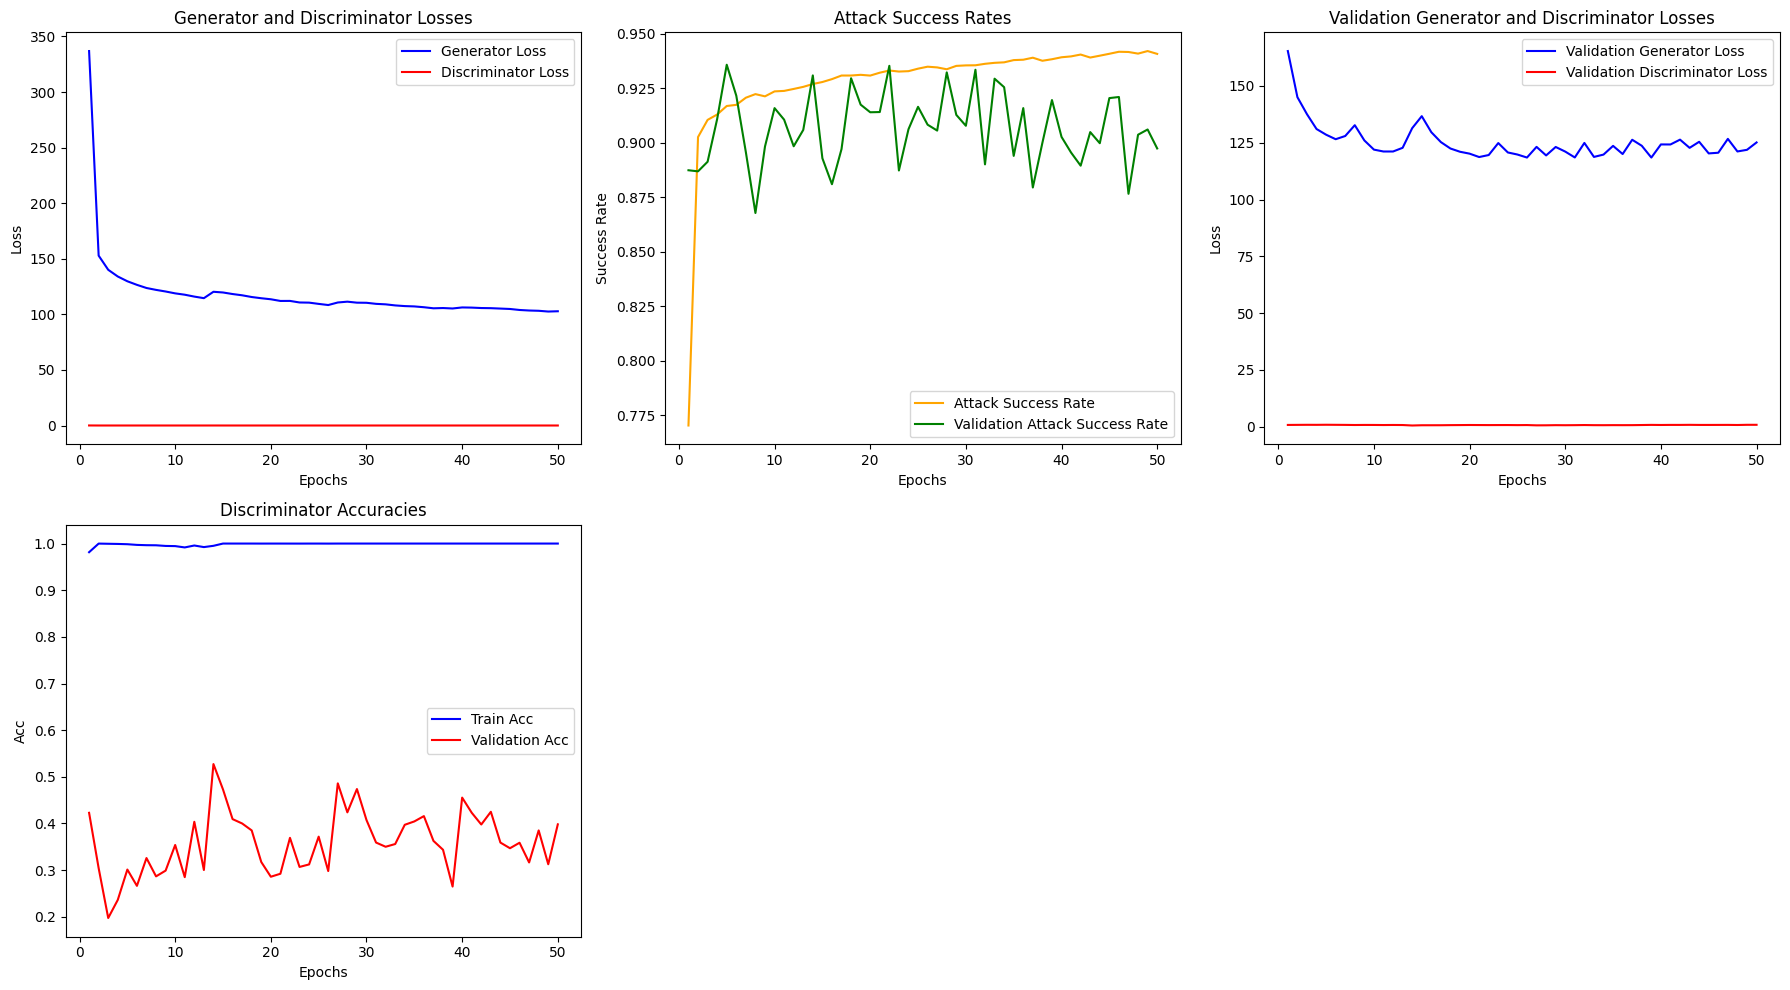

In [19]:
plot_losses(epochs, g_losses, d_losses, attack_success_rates, val_g_losses, val_d_losses, val_attack_success_rates, d_accuracies, val_d_accuracies)

In [20]:
G = Generator().to(device)
D = Discriminator().to(device)

G.load_state_dict(torch.load('best_generator.pth', weights_only=True))
D.load_state_dict(torch.load('best_discriminator.pth', weights_only=True))

overall_rate, per_class_rate = calculate_attack_success(target_model, test_loader, G)

print(f"Overall Attack Success Rate: {overall_rate * 100:.2f}%")
for i, class_name in enumerate(CLASSES):
    print(f"Class {class_name}: {per_class_rate[i] * 100:.2f}%")

Overall Attack Success Rate: 92.35%
Class airplane: 88.30%
Class automobile: 90.30%
Class bird: 88.90%
Class cat: 65.20%
Class deer: 99.80%
Class dog: 100.00%
Class frog: 96.80%
Class horse: 99.70%
Class ship: 96.40%
Class truck: 98.10%


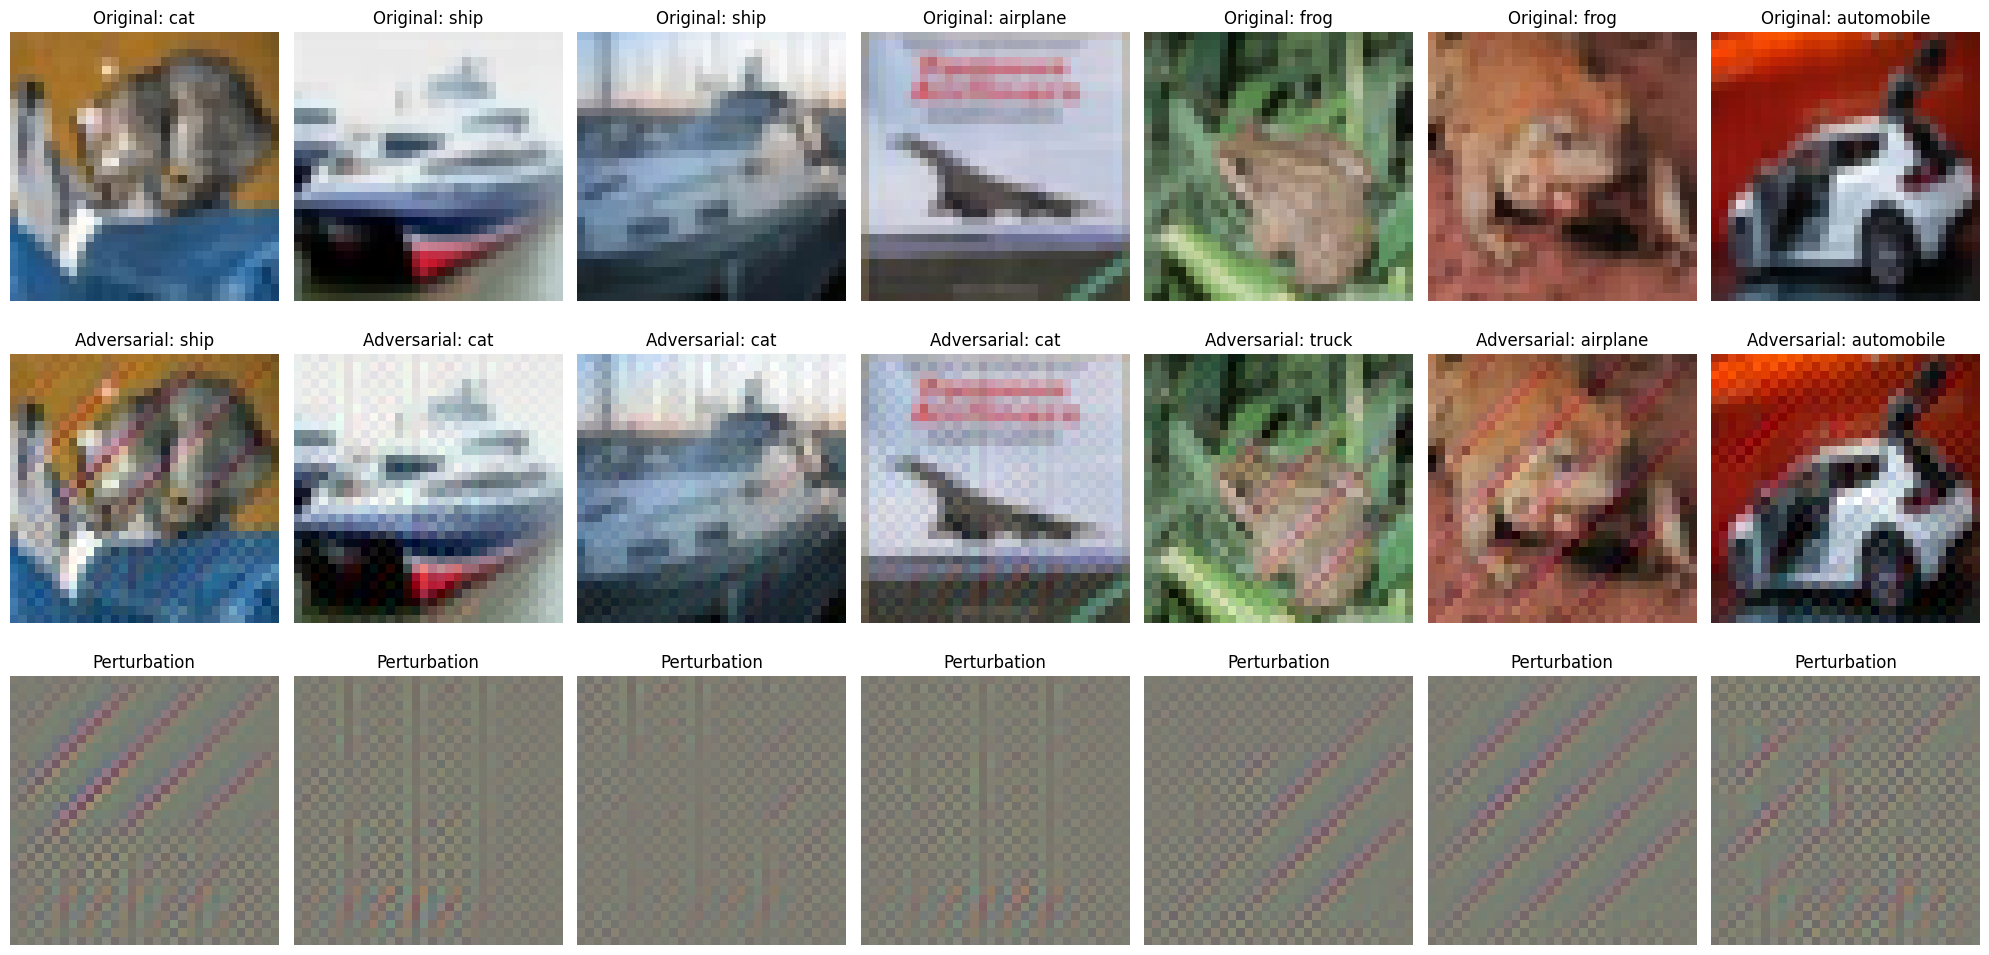

In [21]:
visualize_adversarial_samples(G, test_loader, target_model)

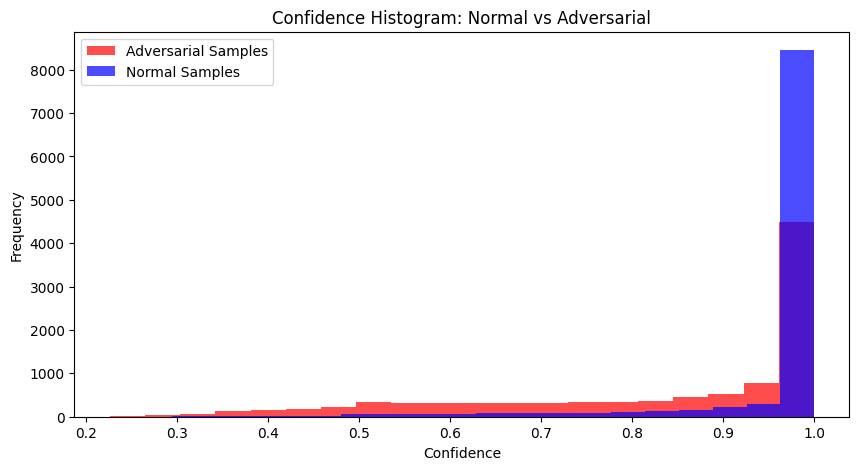

In [22]:
plot_confidence_histograms(target_model, test_loader, G)

In [ ]:
class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512)
        )
        self.decoder = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            # nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            # nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),

            nn.Tanh()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the (32, 4, 4) output to (512)
            nn.Linear(32 * 4 * 4, 1),  # Linear layer for classification
            nn.Sigmoid()  # Normalize output to [0, 1]
        )
    
    def forward(self, x):
        # return self.model(x).view(-1)
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output.view(-1)

In [ ]:
class LossFunctions:
    @staticmethod
    def gan_loss():
        return nn.MSELoss()

    @staticmethod
    def targeted_adv_loss(logits, target, kappa=0):
        target_one_hot = torch.eye(num_classes).type(logits.type())[target.long()]
        real = torch.sum(target_one_hot * logits, 1)
        other = torch.max((1 - target_one_hot) * logits - (target_one_hot * 10000), 1)[0]
        kappa = torch.zeros_like(other).fill_(kappa)
        return torch.sum(torch.max(real - other, kappa))
    
    @staticmethod
    def hinge_loss(perturb, c):
        norm = torch.norm(perturb.view(perturb.size(0), -1), dim=1)
        clamped = torch.clamp(norm - c, min=0)
        return torch.mean(clamped)

    @staticmethod
    def total_loss(adv_loss_value, gan_loss_value, hinge_loss_value, alpha, beta):
        return alpha * gan_loss_value + beta * hinge_loss_value + adv_loss_value

    @staticmethod
    def total_gan_loss(real_loss, fake_loss):
        return real_loss + fake_loss
        real_loss = LossFunctions.gan_loss()(D_targeted(images), torch.ones(batch_size, device=device))
        fake_loss = LossFunctions.gan_loss()(D_targeted(adversarial_images.detach()), torch.zeros(batch_size, device=device))

In [ ]:
def calculate_targeted_attack_success(target_model, test_loader, generator):
    overall_success = 0
    per_class_success = np.zeros(num_classes)
    per_class_count = np.zeros(num_classes)

    generator.eval()
    target_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            target_labels = (labels + 1).to(device) % num_classes
            perturbations = generator(images)
            adv_images = images + perturbations
            adv_outputs = target_model(adv_images)
            _, adv_preds = adv_outputs.max(1)
            fooled = (adv_preds != target_labels).cpu().numpy()
            overall_success += fooled.sum()
            for label, is_fooled, target_label in zip(labels.cpu().numpy(), fooled, target_labels.cpu().numpy()):
                per_class_count[label] += 1
                per_class_success[target_label] += is_fooled
    overall_rate = overall_success / sum(per_class_count)
    per_class_rate = per_class_success / per_class_count
    return overall_rate, per_class_rate

def targeted_attack_success(model, adversarial_images, target_labels):
    with torch.no_grad():
        adv_preds = model(adversarial_images).argmax(dim=1)
        success = (target_labels == adv_preds).sum().item()
    return success

def train_epoch_targeted(epoch, G_targeted, D_targeted, train_loader, optimizer_G, optimizer_D, target_model, alpha, beta, epochs):
    G_targeted.train(), D_targeted.train()
    train_g_loss, train_d_loss, train_attack_success_counts, correct_d = 0, 0, 0, 0
    total_samples = 0
    tepoch = tqdm(train_loader, unit="batch", desc=f"Training Epoch {epoch+1}/{epochs}", ncols=100, leave=False)
    for batch_idx, (images, labels) in enumerate(tepoch):
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        total_samples += batch_size
        target_labels = (labels + 1).to(device) % num_classes
        perturbations = G_targeted(images)
        adversarial_images = images + perturbations

        optimizer_D.zero_grad()
        d_loss = LossFunctions.total_gan_loss(
            real_loss=LossFunctions.gan_loss()(D_targeted(images), torch.ones(batch_size, device=device)),
            fake_loss=LossFunctions.gan_loss()(D_targeted(adversarial_images.detach()), torch.zeros(batch_size, device=device))
        )
        d_loss.backward()
        optimizer_D.step()
        correct_d += ((D_targeted(images) > 0.5).sum() + (D_targeted(adversarial_images.detach()) < 0.5).sum()).item()

        optimizer_G.zero_grad()
        g_loss = LossFunctions.total_loss(
            adv_loss_value=LossFunctions.targeted_adv_loss(target_model(adversarial_images), target_labels),
            gan_loss_value=LossFunctions.gan_loss()(D_targeted(adversarial_images), torch.ones(batch_size, device=device)),
            hinge_loss_value=LossFunctions.hinge_loss(perturbations, c),
            alpha=alpha, beta=beta
        )
        g_loss.backward()
        optimizer_G.step()
        
        train_g_loss += g_loss.item()
        train_d_loss += d_loss.item()
        train_attack_success_counts += targeted_attack_success(target_model, adversarial_images, target_labels)
        tepoch.set_postfix({'Batch': batch_idx + 1, 'G_Loss': g_loss.item(), 'D_Loss': d_loss.item()})
    return (train_g_loss / len(train_loader)), (train_d_loss / len(train_loader)), (train_attack_success_counts / len(train_dataset)), (correct_d / (total_samples * 2))

def validate_epoch_targeted(G_targeted, D_targeted, val_loader, target_model, alpha, beta):
    G_targeted.eval(), D_targeted.eval()
    val_g_loss, val_d_loss, val_attack_success_counts, val_correct_d = 0, 0, 0, 0
    total_samples = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            batch_size = val_images.size(0)
            target_labels = (val_labels + 1).to(device) % num_classes
            total_samples += batch_size
            val_perturbations = G_targeted(val_images)
            val_adversarial_images = val_images + val_perturbations
            val_d_loss_batch = LossFunctions.total_gan_loss(
                real_loss = LossFunctions.gan_loss()(D_targeted(val_images), torch.ones(batch_size, device=device)),
                fake_loss = LossFunctions.gan_loss()(D_targeted(val_adversarial_images), torch.zeros(batch_size, device=device))
            )
            val_g_loss_batch = LossFunctions.total_loss(
                adv_loss_value=LossFunctions.targeted_adv_loss(target_model(val_adversarial_images), target_labels),
                gan_loss_value=LossFunctions.gan_loss()(D_targeted(val_adversarial_images), torch.ones(batch_size, device=device)), 
                hinge_loss_value=LossFunctions.hinge_loss(val_perturbations, c), 
                alpha=alpha, beta=beta
            )
            val_correct_d += ((D_targeted(val_images) > 0.5).sum() + (D_targeted(val_adversarial_images) < 0.5).sum()).item()
            val_g_loss += val_g_loss_batch.item()
            val_d_loss += val_d_loss_batch.item()
            val_attack_success_counts += targeted_attack_success(target_model, val_adversarial_images, target_labels)
    return (val_g_loss/len(val_loader)), (val_d_loss/len(val_loader)), (val_attack_success_counts/len(val_dataset)), (val_correct_d / (total_samples * 2))

In [ ]:
t_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
t_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

t_train_size = int(0.8 * len(t_dataset))
t_val_size = len(t_dataset) - t_train_size
t_train_dataset, t_val_dataset = random_split(t_dataset, [t_train_size, t_val_size])

t_train_loader = DataLoader(t_train_dataset, batch_size=batch_size, shuffle=True)
t_val_loader   = DataLoader(t_val_dataset,   batch_size=batch_size, shuffle=False)
t_test_loader  = DataLoader(t_test_dataset,  batch_size=batch_size, shuffle=False)

In [ ]:
epochs   = 50 
lr       = 0.001
alpha    = 1.0  # param alpha: Weight for adversarial loss (LGAN) 
beta     = 10.0 # param beta: Weight for hinge loss (Lhinge)
c        = 8 / (255 * torch.tensor(std).max().item()) # param c: Hinge loss bound
patience = 7

G_targeted = Generator2().to(device)
D_targeted = Discriminator2().to(device)

optimizer_G_targeted = optim.Adam(G_targeted.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_targeted = optim.Adam(D_targeted.parameters(), lr=lr, betas=(0.5, 0.999))

g_scheduler_targeted = StepLR(optimizer_G_targeted, step_size=8, gamma=0.5)
d_scheduler_targeted = StepLR(optimizer_D_targeted, step_size=8, gamma=0.5)

In [ ]:
targeted_best_val_loss = float('inf')
targeted_patience_counter = 0 
targeted_g_losses, targeted_d_losses, targeted_g_accuracies, targeted_d_accuracies = [], [], [], []
targeted_val_g_losses, targeted_val_d_losses, targeted_val_d_accuracies = [], [], []
targeted_attack_success_rates, targeted_val_attack_success_rates = [], []

for epoch in range(epochs):    
    targeted_g_loss, targeted_d_loss, targeted_attack_success_rate, targeted_d_acc = train_epoch_targeted(
        epoch, G_targeted, D_targeted, t_train_loader, optimizer_G_targeted, optimizer_D_targeted, target_model, alpha, beta, epochs
    )
    targeted_g_losses.append(targeted_g_loss)
    targeted_d_losses.append(targeted_d_loss)
    targeted_d_accuracies.append(targeted_d_acc)
    targeted_attack_success_rates.append(targeted_attack_success_rate)
    
    targeted_val_g_loss, targeted_val_d_loss, targeted_val_attack_success_rate, targeted_val_d_acc = validate_epoch_targeted(
        G_targeted, D_targeted, t_val_loader, target_model, alpha, beta
    )
    targeted_val_g_losses.append(targeted_val_g_loss)
    targeted_val_d_losses.append(targeted_val_d_loss)
    targeted_val_d_accuracies.append(targeted_val_d_acc)
    targeted_val_attack_success_rates.append(targeted_val_attack_success_rate)
    
    print(f"Epoch {epoch+1}/{epochs} | g_loss: {targeted_g_loss:.4f}, d_loss: {targeted_d_loss:.4f}, val_g_loss: {targeted_val_g_loss:.4f}, val_d_loss: {targeted_val_d_loss:.4f}, attack_success_rate: {targeted_attack_success_rate:.4f}, val_attack_success_rate: {targeted_val_attack_success_rate:.4f}")

    if targeted_patience_counter == 4:
        g_scheduler_targeted.step(), d_scheduler_targeted.step()
        print(f"Generator Lr: {g_scheduler_targeted.get_last_lr()[0]}, Discriminator Lr: {d_scheduler_targeted.get_last_lr()[0]}")         
    if targeted_val_g_loss < targeted_best_val_loss:
        targeted_best_val_loss = targeted_val_g_loss
        targeted_patience_counter = 0
        torch.save(G_targeted.state_dict(), 'best_generator_targeted.pth')
        torch.save(D_targeted.state_dict(), 'best_discriminator_targeted.pth')
    else:
        print(f"Patience counter: {targeted_patience_counter + 1}/{patience}")
        targeted_patience_counter += 1
    if targeted_patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
plot_losses(epochs, targeted_g_losses, targeted_d_losses, targeted_attack_success_rates, targeted_val_g_losses, targeted_val_d_losses, targeted_val_attack_success_rates, targeted_d_accuracies, targeted_val_d_accuracies)


In [ ]:
overall_rate, per_class_rate = calculate_targeted_attack_success(target_model, t_test_loader, G_targeted)

print(f"Overall Attack Success Rate: {overall_rate * 100:.2f}%")
for i, class_name in enumerate(CLASSES):
    print(f"Class {class_name}: {per_class_rate[i] * 100:.2f}%")

In [ ]:
visualize_adversarial_samples(G_targeted, t_test_loader, target_model)

In [ ]:
plot_confidence_histograms(target_model, t_test_loader, G_targeted)